In [2]:
import tensorflow_mri as tfmr
import numpy as np
from sklearn.model_selection import train_test_split
from glob import glob
import tensorflow as tf
import tensorflow.keras.backend as K
import random
import matplotlib.pyplot as plt
from skimage import exposure
import scipy
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

2023-08-08 13:45:38.448638: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


New segmentations (n=21) from Karan

In [2]:
import neptune
from neptune.new.integrations.tensorflow_keras import NeptuneCallback

continue_training = True
model_name = 'AOR-29'

/usr/local/lib/python3.8/dist-packages/neptune/internal/backends/hosted_client.py:50: NeptuneDeprecationWarning: The 'neptune-client' package has been deprecated and will be removed in the future. Install the 'neptune' package instead. For more, see https://docs.neptune.ai/setup/upgrading/
  from neptune.version import version as neptune_client_version
/tmp/ipykernel_1744010/525407255.py:2: NeptuneDeprecationWarning: You're importing the Neptune client library via the deprecated `neptune.new` module, which will be removed in a future release. Import directly from `neptune` instead.
  from neptune.new.integrations.tensorflow_keras import NeptuneCallback


In [3]:
if continue_training:
    run = neptune.init_run(
        project="Aorta/Aorta-raw",
        api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIzMjE2ZWMxNi04ZjNkLTRjYjctYWQ1Ni1mY2EyNTU2ZGViYTMifQ==",
        with_id = model_name)  

else:
    run = neptune.init_run(
        project="Aorta/Aorta-raw",
        api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIzMjE2ZWMxNi04ZjNkLTRjYjctYWQ1Ni1mY2EyNTU2ZGViYTMifQ==",
    )  # your credentials
    model_name = list(run.__dict__.values())[-6]

/tmp/ipykernel_1744010/625125474.py:2: NeptuneWarning: To avoid unintended consumption of logging hours during interactive sessions, the following monitoring options are disabled unless set to 'True' when initializing the run: 'capture_stdout', 'capture_stderr', and 'capture_hardware_metrics'.
  run = neptune.init_run(


https://app.neptune.ai/Aorta/Aorta-raw/e/AOR-29


In [4]:
patients = [pat.replace('.npy','') for pat in glob('data/Karan_37/*')] 
train_patients, val_patients = train_test_split(patients,test_size=0.2)

In [7]:
len(train_patients) # (16:5)

29

In [5]:
class CustomDataGen():    
    def __init__(self, patients, cohort):
        random.shuffle(patients)
        self.patients = patients
        self.cohort = cohort                
    def data_generator(self):
        for patient in self.patients:
            image_mask = np.load(f"{patient}.npy")
            image = image_mask[...,0][...,np.newaxis]
            mask = image_mask[...,1][...,np.newaxis]
            bkg = np.zeros(mask.shape[:2])
            bkg = np.where(np.sum(mask,-1) == 1, 0, 1)
            mask = np.concatenate([bkg[...,np.newaxis],mask], -1)
            image= aug_down_gamma_up(image)
            yield normalize(image), mask.astype('uint8')           
    def get_gen(self):
        return self.data_generator() 	   
def normalize(image):
    mean = np.mean(image)
    std = np.std(image)
    if std != 0:
        norm = (image - mean) / std
    else:
        norm = np.zeros_like(image)
    return norm

def random_gamma(image):#input should be 3d image only
    num_slice = random.randint(0, 3) 
    if num_slice != 0:
        start_slice = random.randint(0, image.shape[0]-4)
        selected_slices = list(range(start_slice, start_slice + num_slice))
        for i in range(num_slice):
            slice_i = image[selected_slices[i], :, :, 0]
            slice_i = np.clip(slice_i, 0, None)
            gamma=round(np.random.beta(1, 5) * 0.2 + 0.5, 1) #AOR-10 50% gamma=0.55; AOR-11 60% gamma=0.5; AOR-12 gamma=(0.5,0.7) but skewed to 0.5
            ad_slice = exposure.adjust_gamma(slice_i, gamma)
            image[selected_slices[i], :, :, 0] = ad_slice
    return image

def random_dark(image):#input should be 3d image only
    num_slice = random.randint(0, 2) 
    if num_slice != 0:
        start_slice = random.randint(0, image.shape[0]-5)
        selected_slices = list(range(start_slice, start_slice + num_slice))
        for i in range(num_slice):
            slice_i = image[selected_slices[i], :, :, 0]
            slice_i = np.clip(slice_i, 0, None)
            gamma=round(random.uniform(1.2, 1.5), 1) 
            ad_slice = exposure.adjust_gamma(slice_i, gamma)
            image[selected_slices[i], :, :, 0] = ad_slice
    return image

def aug_down_gamma_up(image):
    adj_image=scipy.ndimage.zoom(image, (1/7.2,1,1,1), order=1, mode='constant')
    gamma_image=random_gamma(adj_image)
    gamma_image=random_dark(adj_image)
    image=scipy.ndimage.zoom(gamma_image, (7.2,1,1,1), order=3, mode='constant')
    return image

In [6]:
def iou(y_true, y_pred, dtype=tf.float32):
    # tf tensor casting
    y_pred = tf.convert_to_tensor(y_pred)
    y_pred = tf.cast(y_pred[...,1:], dtype)
    y_true = tf.cast(y_true[...,1:], y_pred.dtype)

    y_pred = tf.squeeze(y_pred)
    y_true = tf.squeeze(y_true)
    
    y_true_pos = tf.reshape(y_true, [-1])
    y_pred_pos = tf.reshape(y_pred, [-1])

    area_intersect = tf.reduce_sum(tf.multiply(y_true_pos, y_pred_pos))
    
    area_true = tf.reduce_sum(y_true_pos)
    area_pred = tf.reduce_sum(y_pred_pos)
    area_union = area_true + area_pred - area_intersect
    
    return tf.math.divide_no_nan(area_intersect, area_union)

def dice_coef(y_true, y_pred, const=K.epsilon()):
    
    # flatten 2-d tensors
    y_true_pos = tf.reshape(y_true[...,1:], [-1])
    y_pred_pos = tf.reshape(y_pred[...,1:], [-1])
    
    # get true pos (TP), false neg (FN), false pos (FP).
    true_pos  = tf.reduce_sum(y_true_pos * y_pred_pos)
    false_neg = tf.reduce_sum(y_true_pos * (1-y_pred_pos))
    false_pos = tf.reduce_sum((1-y_true_pos) * y_pred_pos)
    
    # 2TP/(2TP+FP+FN) == 2TP/()
    coef_val = (2.0 * true_pos + const)/(2.0 * true_pos + false_pos + false_neg)
    
    return coef_val


In [15]:
output_channel=2
batch_size = 1
input_shape = [None,None,None,1]
output_shape = [None,None,None,output_channel] #output channel=2

train_gen = CustomDataGen(train_patients, 'train').get_gen
val_gen   = CustomDataGen(val_patients, 'val').get_gen


output_signature = (tf.TensorSpec(shape=input_shape, dtype=tf.float32), 
                tf.TensorSpec(shape=output_shape, dtype=tf.float32))

train_ds = tf.data.Dataset.from_generator(train_gen, 
                                          output_signature = output_signature)
val_ds = tf.data.Dataset.from_generator(val_gen, 
                                        output_signature = output_signature)

train_ds = train_ds.shuffle(8, seed = 42, reshuffle_each_iteration=True).batch(batch_size).prefetch(-1)
val_ds = val_ds.batch(batch_size).prefetch(-1)

In [16]:
X, y = next(iter(train_ds))

2023-08-04 13:53:57.129746: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 8
2023-08-04 13:54:06.423895: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 5 of 8
2023-08-04 13:54:15.766778: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 7 of 8
2023-08-04 13:54:20.429442: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


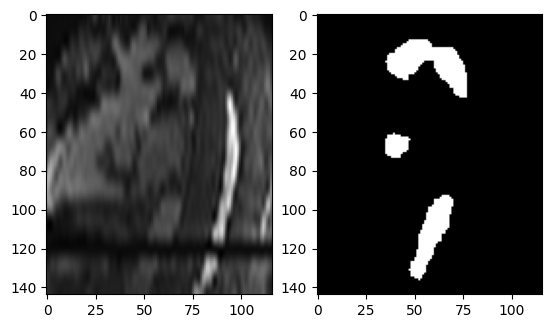

In [20]:
ig, axs = plt.subplots(1,2)

i = 0
axs[0].imshow(X[i,...,51,0],cmap='gray')
axs[1].imshow(y[i,...,51,1],cmap='gray')

In [21]:
if continue_training:
    model = tf.keras.models.load_model(f'models/{model_name}', compile = False)
else:
    inputs = tf.keras.Input(shape = [None,None,None,1]) #define input_shape don't need to specify batch size
    tf.keras.backend.clear_session()
    model = tfmr.models.UNet3D (filters=[64,128,256],
                        kernel_size=3,
                        out_activation='softmax',
                        out_channels = output_channel,
                        use_batch_norm=True)

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(), metrics=[dice_coef,iou])

In [22]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor='loss', 
                   mode='min', 
                   verbose = 1, 
                   patience = 10)
mc = ModelCheckpoint(f'models/{model_name}',
                  save_best_only= True,
                    monitor='val_loss',
                    mode='min')
neptune_callback = NeptuneCallback(run = run)
model.fit(train_ds,
          validation_data = val_ds, 
          epochs=150,
          callbacks=[es, mc, neptune_callback])
          
run['model'].upload(f'models/{model_name}')

Epoch 1/150


/home/vscode/.local/lib/python3.8/site-packages/neptune_tensorflow_keras/impl/__init__.py:152: NeptuneUnsupportedType: You're attempting to log a type that is not directly supported by Neptune (<class 'NoneType'>).
        Convert the value to a supported type, such as a string or float, or use stringify_unsupported(obj)
        for dictionaries or collections that contain unsupported values.
        For more, see https://docs.neptune.ai/help/value_of_unsupported_type
  self._metric_logger["fit_params"] = self.params
2023-08-04 13:55:43.351905: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 8
2023-08-04 13:55:52.605963: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 5 of 8
2023-08-04 13:56:01.898035: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 7 of 8
2023-08-04 13:56:06.534055: I tensorflow/core

     29/Unknown - 146s 3s/step - loss: 0.1402 - dice_coef: 0.2450 - iou: 0.1417

INFO:tensorflow:Assets written to: models/AOR-29/assets


INFO:tensorflow:Assets written to: models/AOR-29/assets


29/29 [==============================] - 189s 5s/step - loss: 0.1402 - dice_coef: 0.2450 - iou: 0.1417 - val_loss: 0.5982 - val_dice_coef: 0.0900 - val_iou: 0.0472
Epoch 2/150


2023-08-04 13:58:50.671258: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 8
2023-08-04 13:58:59.982119: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 5 of 8
2023-08-04 13:59:09.310444: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 7 of 8
2023-08-04 13:59:13.952410: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


29/29 [==============================] - ETA: 0s - loss: 0.1280 - dice_coef: 0.2517 - iou: 0.1463

INFO:tensorflow:Assets written to: models/AOR-29/assets


INFO:tensorflow:Assets written to: models/AOR-29/assets


29/29 [==============================] - 181s 5s/step - loss: 0.1280 - dice_coef: 0.2517 - iou: 0.1463 - val_loss: 0.1555 - val_dice_coef: 0.1647 - val_iou: 0.0912
Epoch 3/150


2023-08-04 14:01:51.846716: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 8
2023-08-04 14:02:01.167818: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 5 of 8
2023-08-04 14:02:10.517558: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 7 of 8
2023-08-04 14:02:15.172312: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


29/29 [==============================] - 176s 5s/step - loss: 0.1214 - dice_coef: 0.2654 - iou: 0.1551 - val_loss: 0.1607 - val_dice_coef: 0.2788 - val_iou: 0.1631
Epoch 4/150


2023-08-04 14:04:48.484027: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 8
2023-08-04 14:04:57.879320: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 5 of 8
2023-08-04 14:05:07.236082: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 7 of 8
2023-08-04 14:05:11.895349: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


29/29 [==============================] - ETA: 0s - loss: 0.1144 - dice_coef: 0.2729 - iou: 0.1606

INFO:tensorflow:Assets written to: models/AOR-29/assets


INFO:tensorflow:Assets written to: models/AOR-29/assets


29/29 [==============================] - 182s 5s/step - loss: 0.1144 - dice_coef: 0.2729 - iou: 0.1606 - val_loss: 0.1197 - val_dice_coef: 0.1516 - val_iou: 0.0844
Epoch 5/150


2023-08-04 14:07:50.317308: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 8
2023-08-04 14:07:59.562824: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 5 of 8
2023-08-04 14:08:08.830286: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 7 of 8
2023-08-04 14:08:13.474740: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


29/29 [==============================] - ETA: 0s - loss: 0.1075 - dice_coef: 0.2872 - iou: 0.1704

INFO:tensorflow:Assets written to: models/AOR-29/assets


INFO:tensorflow:Assets written to: models/AOR-29/assets


29/29 [==============================] - 180s 5s/step - loss: 0.1075 - dice_coef: 0.2872 - iou: 0.1704 - val_loss: 0.1111 - val_dice_coef: 0.2151 - val_iou: 0.1254
Epoch 6/150


2023-08-04 14:10:50.459927: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 8
2023-08-04 14:10:59.736028: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 5 of 8
2023-08-04 14:11:09.017978: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 7 of 8
2023-08-04 14:11:13.662309: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


29/29 [==============================] - ETA: 0s - loss: 0.1026 - dice_coef: 0.2942 - iou: 0.1751

INFO:tensorflow:Assets written to: models/AOR-29/assets


INFO:tensorflow:Assets written to: models/AOR-29/assets


29/29 [==============================] - 180s 5s/step - loss: 0.1026 - dice_coef: 0.2942 - iou: 0.1751 - val_loss: 0.1030 - val_dice_coef: 0.2317 - val_iou: 0.1339
Epoch 7/150


2023-08-04 14:13:50.874356: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 8
2023-08-04 14:14:00.134028: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 5 of 8
2023-08-04 14:14:09.395686: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 7 of 8
2023-08-04 14:14:14.040264: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


29/29 [==============================] - ETA: 0s - loss: 0.0981 - dice_coef: 0.3168 - iou: 0.1921

INFO:tensorflow:Assets written to: models/AOR-29/assets


INFO:tensorflow:Assets written to: models/AOR-29/assets


29/29 [==============================] - 180s 5s/step - loss: 0.0981 - dice_coef: 0.3168 - iou: 0.1921 - val_loss: 0.0891 - val_dice_coef: 0.2357 - val_iou: 0.1390
Epoch 8/150


2023-08-04 14:16:50.945312: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 8
2023-08-04 14:17:00.189089: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 5 of 8
2023-08-04 14:17:09.444191: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 7 of 8
2023-08-04 14:17:14.078767: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


29/29 [==============================] - 175s 5s/step - loss: 0.1003 - dice_coef: 0.2931 - iou: 0.1745 - val_loss: 0.3073 - val_dice_coef: 0.2198 - val_iou: 0.1265
Epoch 9/150


2023-08-04 14:19:45.818973: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 8
2023-08-04 14:19:55.067426: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 5 of 8
2023-08-04 14:20:04.354248: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 7 of 8
2023-08-04 14:20:08.986502: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


29/29 [==============================] - ETA: 0s - loss: 0.0891 - dice_coef: 0.3147 - iou: 0.1896

INFO:tensorflow:Assets written to: models/AOR-29/assets


INFO:tensorflow:Assets written to: models/AOR-29/assets


29/29 [==============================] - 180s 5s/step - loss: 0.0891 - dice_coef: 0.3147 - iou: 0.1896 - val_loss: 0.0835 - val_dice_coef: 0.2996 - val_iou: 0.1817
Epoch 10/150


2023-08-04 14:22:46.173705: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 8
2023-08-04 14:22:55.421423: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 5 of 8
2023-08-04 14:23:04.678657: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 7 of 8
2023-08-04 14:23:09.313387: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


29/29 [==============================] - ETA: 0s - loss: 0.0911 - dice_coef: 0.3223 - iou: 0.1955

INFO:tensorflow:Assets written to: models/AOR-29/assets


INFO:tensorflow:Assets written to: models/AOR-29/assets


29/29 [==============================] - 180s 5s/step - loss: 0.0911 - dice_coef: 0.3223 - iou: 0.1955 - val_loss: 0.0833 - val_dice_coef: 0.2417 - val_iou: 0.1454
Epoch 11/150


2023-08-04 14:25:46.029373: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 8
2023-08-04 14:25:55.269553: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 5 of 8
2023-08-04 14:26:04.493470: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 7 of 8
2023-08-04 14:26:09.103763: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


29/29 [==============================] - ETA: 0s - loss: 0.0847 - dice_coef: 0.3279 - iou: 0.1992

INFO:tensorflow:Assets written to: models/AOR-29/assets


INFO:tensorflow:Assets written to: models/AOR-29/assets


29/29 [==============================] - 180s 5s/step - loss: 0.0847 - dice_coef: 0.3279 - iou: 0.1992 - val_loss: 0.0738 - val_dice_coef: 0.2970 - val_iou: 0.1797
Epoch 12/150


2023-08-04 14:28:45.792896: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 8
2023-08-04 14:28:55.024122: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 5 of 8
2023-08-04 14:29:04.270846: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 7 of 8
2023-08-04 14:29:08.898806: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


29/29 [==============================] - ETA: 0s - loss: 0.0785 - dice_coef: 0.3515 - iou: 0.2164

INFO:tensorflow:Assets written to: models/AOR-29/assets


INFO:tensorflow:Assets written to: models/AOR-29/assets


29/29 [==============================] - 180s 5s/step - loss: 0.0785 - dice_coef: 0.3515 - iou: 0.2164 - val_loss: 0.0725 - val_dice_coef: 0.3065 - val_iou: 0.1885
Epoch 13/150


2023-08-04 14:31:46.032246: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 8
2023-08-04 14:31:55.284172: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 5 of 8
2023-08-04 14:32:04.558525: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 7 of 8
2023-08-04 14:32:09.189811: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


29/29 [==============================] - 175s 5s/step - loss: 0.0786 - dice_coef: 0.3619 - iou: 0.2262 - val_loss: 0.0974 - val_dice_coef: 0.2770 - val_iou: 0.1625
Epoch 14/150


2023-08-04 14:34:41.092054: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 8
2023-08-04 14:34:50.339076: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 5 of 8
2023-08-04 14:34:59.557444: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 7 of 8
2023-08-04 14:35:04.187368: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


29/29 [==============================] - 175s 5s/step - loss: 0.0780 - dice_coef: 0.3523 - iou: 0.2174 - val_loss: 0.0845 - val_dice_coef: 0.3148 - val_iou: 0.1911
Epoch 15/150


2023-08-04 14:37:36.117974: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 8
2023-08-04 14:37:45.361114: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 5 of 8
2023-08-04 14:37:54.602999: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 7 of 8
2023-08-04 14:37:59.249045: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


29/29 [==============================] - 175s 5s/step - loss: 0.0716 - dice_coef: 0.3782 - iou: 0.2377 - val_loss: 0.0781 - val_dice_coef: 0.3046 - val_iou: 0.1852
Epoch 16/150


2023-08-04 14:40:31.234007: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 8
2023-08-04 14:40:40.480238: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 5 of 8
2023-08-04 14:40:49.751912: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 7 of 8
2023-08-04 14:40:54.363207: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


29/29 [==============================] - 175s 5s/step - loss: 0.0734 - dice_coef: 0.3755 - iou: 0.2357 - val_loss: 0.0775 - val_dice_coef: 0.2257 - val_iou: 0.1353
Epoch 17/150


2023-08-04 14:43:26.583728: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 8
2023-08-04 14:43:35.848724: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 5 of 8
2023-08-04 14:43:45.124699: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 7 of 8
2023-08-04 14:43:49.758831: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


29/29 [==============================] - ETA: 0s - loss: 0.0666 - dice_coef: 0.3895 - iou: 0.2462

INFO:tensorflow:Assets written to: models/AOR-29/assets


INFO:tensorflow:Assets written to: models/AOR-29/assets


29/29 [==============================] - 180s 5s/step - loss: 0.0666 - dice_coef: 0.3895 - iou: 0.2462 - val_loss: 0.0576 - val_dice_coef: 0.4139 - val_iou: 0.2655
Epoch 18/150


2023-08-04 14:46:26.843862: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 8
2023-08-04 14:46:36.120166: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 5 of 8
2023-08-04 14:46:45.392546: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 7 of 8
2023-08-04 14:46:50.031548: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


29/29 [==============================] - 175s 5s/step - loss: 0.0602 - dice_coef: 0.4252 - iou: 0.2747 - val_loss: 0.0756 - val_dice_coef: 0.2434 - val_iou: 0.1468
Epoch 19/150


2023-08-04 14:49:22.211958: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 8
2023-08-04 14:49:31.500030: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 5 of 8
2023-08-04 14:49:40.765200: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 7 of 8
2023-08-04 14:49:45.397421: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


29/29 [==============================] - 175s 5s/step - loss: 0.0591 - dice_coef: 0.4251 - iou: 0.2761 - val_loss: 0.0608 - val_dice_coef: 0.3597 - val_iou: 0.2245
Epoch 20/150


2023-08-04 14:52:17.226108: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 8
2023-08-04 14:52:26.478583: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 5 of 8
2023-08-04 14:52:35.729730: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 7 of 8
2023-08-04 14:52:40.355994: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


29/29 [==============================] - 175s 5s/step - loss: 0.0614 - dice_coef: 0.4227 - iou: 0.2741 - val_loss: 0.0720 - val_dice_coef: 0.3422 - val_iou: 0.2114
Epoch 21/150


2023-08-04 14:55:12.195042: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 8
2023-08-04 14:55:21.480999: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 5 of 8
2023-08-04 14:55:30.765606: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 7 of 8
2023-08-04 14:55:35.398890: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


29/29 [==============================] - 175s 5s/step - loss: 0.0659 - dice_coef: 0.4021 - iou: 0.2563 - val_loss: 0.0615 - val_dice_coef: 0.4034 - val_iou: 0.2613
Epoch 22/150


2023-08-04 14:58:07.497785: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 8
2023-08-04 14:58:16.752206: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 5 of 8
2023-08-04 14:58:26.021194: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 7 of 8
2023-08-04 14:58:30.668740: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


29/29 [==============================] - 175s 5s/step - loss: 0.0624 - dice_coef: 0.4148 - iou: 0.2663 - val_loss: 0.0740 - val_dice_coef: 0.3642 - val_iou: 0.2349
Epoch 23/150


2023-08-04 15:01:02.624167: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 8
2023-08-04 15:01:11.877466: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 5 of 8
2023-08-04 15:01:21.138376: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 7 of 8
2023-08-04 15:01:25.767246: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


29/29 [==============================] - 175s 5s/step - loss: 0.0576 - dice_coef: 0.4308 - iou: 0.2802 - val_loss: 0.0642 - val_dice_coef: 0.3307 - val_iou: 0.2103
Epoch 24/150


2023-08-04 15:03:57.543206: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 8
2023-08-04 15:04:06.816189: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 5 of 8
2023-08-04 15:04:16.091373: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 7 of 8
2023-08-04 15:04:20.726966: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


29/29 [==============================] - 175s 5s/step - loss: 0.0732 - dice_coef: 0.4275 - iou: 0.2788 - val_loss: 0.1106 - val_dice_coef: 0.1187 - val_iou: 0.0637
Epoch 25/150


2023-08-04 15:06:52.513242: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 8
2023-08-04 15:07:01.776846: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 5 of 8
2023-08-04 15:07:11.057348: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 7 of 8
2023-08-04 15:07:15.705216: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


29/29 [==============================] - 175s 5s/step - loss: 0.0757 - dice_coef: 0.3844 - iou: 0.2428 - val_loss: 0.0710 - val_dice_coef: 0.4549 - val_iou: 0.2965
Epoch 26/150


2023-08-04 15:09:47.485185: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 8
2023-08-04 15:09:56.755276: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 5 of 8
2023-08-04 15:10:06.018362: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 7 of 8
2023-08-04 15:10:10.641463: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


29/29 [==============================] - 175s 5s/step - loss: 0.0808 - dice_coef: 0.3935 - iou: 0.2487 - val_loss: 0.1164 - val_dice_coef: 0.2367 - val_iou: 0.1371
Epoch 27/150


2023-08-04 15:12:42.675873: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 8
2023-08-04 15:12:51.911336: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 5 of 8
2023-08-04 15:13:01.153974: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 7 of 8
2023-08-04 15:13:05.775135: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


29/29 [==============================] - 175s 5s/step - loss: 0.0611 - dice_coef: 0.4250 - iou: 0.2748 - val_loss: 0.0651 - val_dice_coef: 0.3341 - val_iou: 0.2080
Epoch 28/150


2023-08-04 15:15:37.753032: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 8
2023-08-04 15:15:46.999505: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 5 of 8
2023-08-04 15:15:56.267808: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 7 of 8
2023-08-04 15:16:00.900760: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


29/29 [==============================] - 175s 5s/step - loss: 0.0532 - dice_coef: 0.4652 - iou: 0.3094 - val_loss: 0.0711 - val_dice_coef: 0.2624 - val_iou: 0.1573
Epoch 29/150


2023-08-04 15:18:32.553112: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 8
2023-08-04 15:18:41.807968: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 5 of 8
2023-08-04 15:18:51.067409: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 7 of 8
2023-08-04 15:18:55.700823: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


29/29 [==============================] - 175s 5s/step - loss: 0.0517 - dice_coef: 0.4563 - iou: 0.3024 - val_loss: 0.0688 - val_dice_coef: 0.2822 - val_iou: 0.1730
Epoch 30/150


2023-08-04 15:21:27.791028: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 8
2023-08-04 15:21:37.055685: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 5 of 8
2023-08-04 15:21:46.296675: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 7 of 8
2023-08-04 15:21:50.913382: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


29/29 [==============================] - ETA: 0s - loss: 0.0531 - dice_coef: 0.4598 - iou: 0.3038

INFO:tensorflow:Assets written to: models/AOR-29/assets


INFO:tensorflow:Assets written to: models/AOR-29/assets


29/29 [==============================] - 179s 5s/step - loss: 0.0531 - dice_coef: 0.4598 - iou: 0.3038 - val_loss: 0.0574 - val_dice_coef: 0.3711 - val_iou: 0.2338
Epoch 31/150


2023-08-04 15:24:27.237555: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 8
2023-08-04 15:24:36.501199: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 5 of 8
2023-08-04 15:24:45.757386: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 7 of 8
2023-08-04 15:24:50.387322: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


29/29 [==============================] - ETA: 0s - loss: 0.0500 - dice_coef: 0.4718 - iou: 0.3144

INFO:tensorflow:Assets written to: models/AOR-29/assets


INFO:tensorflow:Assets written to: models/AOR-29/assets


29/29 [==============================] - 180s 5s/step - loss: 0.0500 - dice_coef: 0.4718 - iou: 0.3144 - val_loss: 0.0511 - val_dice_coef: 0.4308 - val_iou: 0.2789
Epoch 32/150


2023-08-04 15:27:27.144955: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 8
2023-08-04 15:27:36.394530: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 5 of 8
2023-08-04 15:27:45.658779: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 7 of 8
2023-08-04 15:27:50.286682: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


29/29 [==============================] - ETA: 0s - loss: 0.0443 - dice_coef: 0.4992 - iou: 0.3392

INFO:tensorflow:Assets written to: models/AOR-29/assets


INFO:tensorflow:Assets written to: models/AOR-29/assets


29/29 [==============================] - 180s 5s/step - loss: 0.0443 - dice_coef: 0.4992 - iou: 0.3392 - val_loss: 0.0473 - val_dice_coef: 0.4656 - val_iou: 0.3072
Epoch 33/150


2023-08-04 15:30:26.738706: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 8
2023-08-04 15:30:35.998995: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 5 of 8
2023-08-04 15:30:45.234169: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 7 of 8
2023-08-04 15:30:49.854517: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


29/29 [==============================] - 175s 5s/step - loss: 0.0424 - dice_coef: 0.5128 - iou: 0.3516 - val_loss: 0.0521 - val_dice_coef: 0.4096 - val_iou: 0.2719
Epoch 34/150


2023-08-04 15:33:21.799042: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 8
2023-08-04 15:33:31.073675: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 5 of 8
2023-08-04 15:33:40.331866: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 7 of 8
2023-08-04 15:33:44.957125: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


29/29 [==============================] - 175s 5s/step - loss: 0.0427 - dice_coef: 0.5120 - iou: 0.3509 - val_loss: 0.0508 - val_dice_coef: 0.4366 - val_iou: 0.2927
Epoch 35/150


2023-08-04 15:36:16.917141: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 8
2023-08-04 15:36:26.213365: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 5 of 8
2023-08-04 15:36:35.454069: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 7 of 8
2023-08-04 15:36:40.086406: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


29/29 [==============================] - ETA: 0s - loss: 0.0412 - dice_coef: 0.5194 - iou: 0.3575

INFO:tensorflow:Assets written to: models/AOR-29/assets


INFO:tensorflow:Assets written to: models/AOR-29/assets


29/29 [==============================] - 180s 5s/step - loss: 0.0412 - dice_coef: 0.5194 - iou: 0.3575 - val_loss: 0.0459 - val_dice_coef: 0.4693 - val_iou: 0.3195
Epoch 36/150


2023-08-04 15:39:16.647869: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 8
2023-08-04 15:39:25.901960: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 5 of 8
2023-08-04 15:39:35.169702: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 7 of 8
2023-08-04 15:39:39.806306: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


29/29 [==============================] - ETA: 0s - loss: 0.0375 - dice_coef: 0.5477 - iou: 0.3833

INFO:tensorflow:Assets written to: models/AOR-29/assets


INFO:tensorflow:Assets written to: models/AOR-29/assets


29/29 [==============================] - 180s 5s/step - loss: 0.0375 - dice_coef: 0.5477 - iou: 0.3833 - val_loss: 0.0411 - val_dice_coef: 0.4966 - val_iou: 0.3352
Epoch 37/150


2023-08-04 15:42:16.446607: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 8
2023-08-04 15:42:25.725929: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 5 of 8
2023-08-04 15:42:35.011372: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 7 of 8
2023-08-04 15:42:39.659861: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


29/29 [==============================] - 175s 5s/step - loss: 0.0381 - dice_coef: 0.5419 - iou: 0.3779 - val_loss: 0.0605 - val_dice_coef: 0.3575 - val_iou: 0.2354
Epoch 38/150


2023-08-04 15:45:11.468401: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 8
2023-08-04 15:45:20.725797: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 5 of 8
2023-08-04 15:45:29.998319: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 7 of 8
2023-08-04 15:45:34.641479: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


29/29 [==============================] - 175s 5s/step - loss: 0.0383 - dice_coef: 0.5457 - iou: 0.3819 - val_loss: 0.0764 - val_dice_coef: 0.2226 - val_iou: 0.1362
Epoch 39/150


2023-08-04 15:48:06.415935: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 8
2023-08-04 15:48:15.676395: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 5 of 8
2023-08-04 15:48:24.940982: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 7 of 8
2023-08-04 15:48:29.563256: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


29/29 [==============================] - 175s 5s/step - loss: 0.0366 - dice_coef: 0.5569 - iou: 0.3930 - val_loss: 0.0507 - val_dice_coef: 0.4384 - val_iou: 0.2935
Epoch 40/150


2023-08-04 15:51:01.252194: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 8
2023-08-04 15:51:10.520522: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 5 of 8
2023-08-04 15:51:19.785004: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 7 of 8
2023-08-04 15:51:24.418338: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


29/29 [==============================] - 175s 5s/step - loss: 0.0360 - dice_coef: 0.5615 - iou: 0.3982 - val_loss: 0.0528 - val_dice_coef: 0.3982 - val_iou: 0.2607
Epoch 41/150


2023-08-04 15:53:56.414711: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 8
2023-08-04 15:54:05.672281: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 5 of 8
2023-08-04 15:54:14.970408: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 7 of 8
2023-08-04 15:54:19.593958: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


29/29 [==============================] - 175s 5s/step - loss: 0.0344 - dice_coef: 0.5696 - iou: 0.4050 - val_loss: 0.0426 - val_dice_coef: 0.4933 - val_iou: 0.3386
Epoch 42/150


2023-08-04 15:56:51.570553: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 8
2023-08-04 15:57:00.827405: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 5 of 8
2023-08-04 15:57:10.086620: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 7 of 8
2023-08-04 15:57:14.721597: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


29/29 [==============================] - 175s 5s/step - loss: 0.0341 - dice_coef: 0.5763 - iou: 0.4120 - val_loss: 0.0425 - val_dice_coef: 0.5131 - val_iou: 0.3624
Epoch 43/150


2023-08-04 15:59:46.816374: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 8
2023-08-04 15:59:56.075812: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 5 of 8
2023-08-04 16:00:05.333858: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 7 of 8
2023-08-04 16:00:09.974140: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


29/29 [==============================] - 175s 5s/step - loss: 0.0382 - dice_coef: 0.5620 - iou: 0.3979 - val_loss: 0.0564 - val_dice_coef: 0.5451 - val_iou: 0.3761
Epoch 44/150


2023-08-04 16:02:42.086460: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 8
2023-08-04 16:02:51.345575: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 5 of 8
2023-08-04 16:03:00.591913: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 7 of 8
2023-08-04 16:03:05.202647: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


29/29 [==============================] - ETA: 0s - loss: 0.0364 - dice_coef: 0.5655 - iou: 0.4015

INFO:tensorflow:Assets written to: models/AOR-29/assets


INFO:tensorflow:Assets written to: models/AOR-29/assets


29/29 [==============================] - 179s 5s/step - loss: 0.0364 - dice_coef: 0.5655 - iou: 0.4015 - val_loss: 0.0330 - val_dice_coef: 0.5844 - val_iou: 0.4147
Epoch 45/150


2023-08-04 16:05:41.400843: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 8
2023-08-04 16:05:50.649219: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 5 of 8
2023-08-04 16:05:59.912167: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 7 of 8
2023-08-04 16:06:04.544524: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


29/29 [==============================] - 175s 5s/step - loss: 0.0323 - dice_coef: 0.5910 - iou: 0.4266 - val_loss: 0.0464 - val_dice_coef: 0.5001 - val_iou: 0.3381
Epoch 46/150


2023-08-04 16:08:36.528675: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 8
2023-08-04 16:08:45.807140: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 5 of 8
2023-08-04 16:08:55.072774: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 7 of 8
2023-08-04 16:08:59.704349: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


29/29 [==============================] - 175s 5s/step - loss: 0.0310 - dice_coef: 0.5964 - iou: 0.4330 - val_loss: 0.0377 - val_dice_coef: 0.5292 - val_iou: 0.3642
Epoch 47/150


2023-08-04 16:11:31.571092: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 8
2023-08-04 16:11:40.833787: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 5 of 8
2023-08-04 16:11:50.103583: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 7 of 8
2023-08-04 16:11:54.734200: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


29/29 [==============================] - 175s 5s/step - loss: 0.0310 - dice_coef: 0.5992 - iou: 0.4345 - val_loss: 0.0511 - val_dice_coef: 0.4114 - val_iou: 0.2771
Epoch 48/150


2023-08-04 16:14:26.551180: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 8
2023-08-04 16:14:35.794600: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 5 of 8
2023-08-04 16:14:45.062367: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 7 of 8
2023-08-04 16:14:49.704762: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


29/29 [==============================] - 175s 5s/step - loss: 0.0312 - dice_coef: 0.5997 - iou: 0.4363 - val_loss: 0.0594 - val_dice_coef: 0.3774 - val_iou: 0.2509
Epoch 49/150


2023-08-04 16:17:21.575048: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 8
2023-08-04 16:17:30.840008: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 5 of 8
2023-08-04 16:17:40.103358: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 7 of 8
2023-08-04 16:17:44.737683: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


29/29 [==============================] - 175s 5s/step - loss: 0.0292 - dice_coef: 0.6174 - iou: 0.4537 - val_loss: 0.0353 - val_dice_coef: 0.5653 - val_iou: 0.4057
Epoch 50/150


2023-08-04 16:20:16.677031: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 8
2023-08-04 16:20:25.945090: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 5 of 8
2023-08-04 16:20:35.197375: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 7 of 8
2023-08-04 16:20:39.823403: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


29/29 [==============================] - 175s 5s/step - loss: 0.0309 - dice_coef: 0.6089 - iou: 0.4446 - val_loss: 0.0430 - val_dice_coef: 0.4849 - val_iou: 0.3308
Epoch 51/150


2023-08-04 16:23:11.601180: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 8
2023-08-04 16:23:20.900068: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 5 of 8
2023-08-04 16:23:30.185532: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 7 of 8
2023-08-04 16:23:34.811601: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


29/29 [==============================] - 175s 5s/step - loss: 0.0285 - dice_coef: 0.6194 - iou: 0.4565 - val_loss: 0.0340 - val_dice_coef: 0.5546 - val_iou: 0.3935
Epoch 52/150


2023-08-04 16:26:06.909616: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 8
2023-08-04 16:26:16.160365: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 5 of 8
2023-08-04 16:26:25.405388: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 7 of 8
2023-08-04 16:26:30.029470: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


29/29 [==============================] - 175s 5s/step - loss: 0.0267 - dice_coef: 0.6353 - iou: 0.4731 - val_loss: 0.0564 - val_dice_coef: 0.4111 - val_iou: 0.2754
Epoch 53/150


2023-08-04 16:29:02.072771: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 8
2023-08-04 16:29:11.327934: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 5 of 8
2023-08-04 16:29:20.593642: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 7 of 8
2023-08-04 16:29:25.223160: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


29/29 [==============================] - 175s 5s/step - loss: 0.0269 - dice_coef: 0.6362 - iou: 0.4755 - val_loss: 0.0472 - val_dice_coef: 0.4788 - val_iou: 0.3414
Epoch 54/150


2023-08-04 16:31:57.092163: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 8
2023-08-04 16:32:06.355409: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 5 of 8
2023-08-04 16:32:15.629516: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 7 of 8
2023-08-04 16:32:20.265851: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


29/29 [==============================] - 175s 5s/step - loss: 0.0277 - dice_coef: 0.6310 - iou: 0.4685 - val_loss: 0.0618 - val_dice_coef: 0.3469 - val_iou: 0.2330
Epoch 55/150


2023-08-04 16:34:52.091708: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 8
2023-08-04 16:35:01.337704: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 5 of 8
2023-08-04 16:35:10.588803: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 7 of 8
2023-08-04 16:35:15.224002: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


29/29 [==============================] - 175s 5s/step - loss: 0.0288 - dice_coef: 0.6261 - iou: 0.4655 - val_loss: 0.0524 - val_dice_coef: 0.4450 - val_iou: 0.3171
Epoch 56/150


2023-08-04 16:37:46.979231: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 8
2023-08-04 16:37:56.227457: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 5 of 8
2023-08-04 16:38:05.477559: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 7 of 8
2023-08-04 16:38:10.095649: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


29/29 [==============================] - ETA: 0s - loss: 0.0286 - dice_coef: 0.6285 - iou: 0.4671

INFO:tensorflow:Assets written to: models/AOR-29/assets


INFO:tensorflow:Assets written to: models/AOR-29/assets


29/29 [==============================] - 180s 5s/step - loss: 0.0286 - dice_coef: 0.6285 - iou: 0.4671 - val_loss: 0.0307 - val_dice_coef: 0.6297 - val_iou: 0.4630
Epoch 57/150


2023-08-04 16:40:46.789328: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 8
2023-08-04 16:40:56.042508: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 5 of 8
2023-08-04 16:41:05.291796: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 7 of 8
2023-08-04 16:41:09.927194: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


29/29 [==============================] - 175s 5s/step - loss: 0.0258 - dice_coef: 0.6507 - iou: 0.4894 - val_loss: 0.0395 - val_dice_coef: 0.5485 - val_iou: 0.3943
Epoch 58/150


2023-08-04 16:43:41.894496: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 8
2023-08-04 16:43:51.150103: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 5 of 8
2023-08-04 16:44:00.389141: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 7 of 8
2023-08-04 16:44:04.997440: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


29/29 [==============================] - 175s 5s/step - loss: 0.0248 - dice_coef: 0.6543 - iou: 0.4938 - val_loss: 0.0430 - val_dice_coef: 0.4984 - val_iou: 0.3597
Epoch 59/150


2023-08-04 16:46:37.192036: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 8
2023-08-04 16:46:46.412926: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 5 of 8
2023-08-04 16:46:55.646150: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 7 of 8
2023-08-04 16:47:00.252029: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


29/29 [==============================] - 175s 5s/step - loss: 0.0243 - dice_coef: 0.6675 - iou: 0.5074 - val_loss: 0.0390 - val_dice_coef: 0.5400 - val_iou: 0.3912
Epoch 60/150


2023-08-04 16:49:31.892885: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 8
2023-08-04 16:49:41.124932: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 5 of 8
2023-08-04 16:49:50.385053: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 7 of 8
2023-08-04 16:49:55.008174: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


20/29 [===================>..........] - ETA: 41s - loss: 0.0287 - dice_coef: 0.6399 - iou: 0.4824

In [9]:
if continue_training:
    model = tf.keras.models.load_model(f'models/{model_name}', compile = False)

2023-08-04 21:50:07.033399: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-04 21:50:07.831211: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46693 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:d8:00.0, compute capability: 8.6


In [10]:
for layer in model.layers:
    print(layer.get_config())

{'filters': ListWrapper([64, 64]), 'kernel_size': 3, 'strides': 1, 'activation': 'relu', 'out_activation': 'same', 'use_bias': True, 'kernel_initializer': 'VarianceScaling', 'bias_initializer': 'Zeros', 'kernel_regularizer': None, 'bias_regularizer': None, 'use_batch_norm': True, 'use_sync_bn': False, 'bn_momentum': 0.99, 'bn_epsilon': 0.001, 'use_residual': False, 'use_dropout': False, 'dropout_rate': 0.3, 'dropout_type': 'standard'}
{'filters': ListWrapper([128, 128]), 'kernel_size': 3, 'strides': 1, 'activation': 'relu', 'out_activation': 'same', 'use_bias': True, 'kernel_initializer': 'VarianceScaling', 'bias_initializer': 'Zeros', 'kernel_regularizer': None, 'bias_regularizer': None, 'use_batch_norm': True, 'use_sync_bn': False, 'bn_momentum': 0.99, 'bn_epsilon': 0.001, 'use_residual': False, 'use_dropout': False, 'dropout_rate': 0.3, 'dropout_type': 'standard'}
{'filters': ListWrapper([256, 256]), 'kernel_size': 3, 'strides': 1, 'activation': 'relu', 'out_activation': 'same', 'us

In [16]:
patient = val_patients[5]
X_test = []
y_test = []
test_gen   = CustomDataGen([patient], 'test').get_gen()
for X, y in test_gen:
    X_test.append(X)
    y_test.append(y)
X_test = np.stack(X_test)
y_test = np.stack(y_test)

In [17]:
def get_one_hot(targets, nb_classes):
    res = np.eye(nb_classes)[np.array(targets).reshape(-1)]
    return res.reshape(list(targets.shape)+[nb_classes])

In [18]:
y_pred = model.predict(X_test)
y_pred = get_one_hot(np.argmax(y_pred,axis = -1), 3)

1/1 [==============================] - 0s 149ms/step


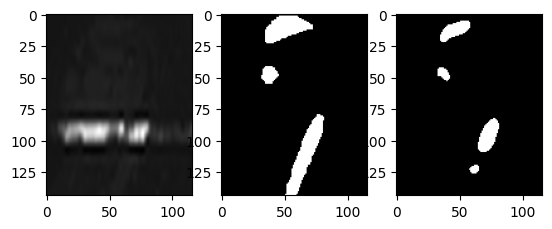

In [20]:
fig, axs = plt.subplots(1,3)

i = 0
axs[0].imshow(X_test[i,...,47,0],cmap='gray')
axs[1].imshow(y_test[i,...,47,1],cmap='gray')
axs[2].imshow(y_pred[i,...,47,1],cmap='gray')

In [21]:
from matplotlib import animation
for patient in val_patients:
    X_test = []
    y_test = []
    test_gen   = CustomDataGen([patient], 'test').get_gen()
    for X, y in test_gen:
        X_test.append(X)
        y_test.append(y)
    X_test = np.stack(X_test)
    y_test = np.stack(y_test)
    y_pred = model.predict(X_test)
    y_pred = get_one_hot(np.argmax(y_pred,axis = -1), 2)

    fig, axs = plt.subplots(1,2, figsize = (7,5))
    frames = []
    for i in range(y_pred.shape[-2]):
        p1 = axs[0].imshow(X_test[0,...,i,0],cmap = 'gray')
        p2 = axs[1].imshow(X_test[0,...,i,0],cmap = 'gray')
        p3 = axs[0].imshow(y_test[0,...,i,-1],alpha=y_test[0,...,i,-1] * 0.7,cmap = 'jet')
        p4 = axs[1].imshow(y_pred[0,...,i,-1],alpha = y_pred[0,...,i,-1] * 0.7,cmap = 'Blues')
        frames.append([p1,p2,p3,p4])
    fig.tight_layout()
    ani = animation.ArtistAnimation(fig, frames)
    ani.save(f'video.gif', fps=y_pred.shape[-2])
    run[f"Train_test_new/{patient.split('/')[-1]}"].upload('video.gif')
    plt.close()

1/1 [==============================] - 0s 155ms/step


In [ ]:
#transverse view
for patient in val_patients:
    X_test = []
    y_test = []
    test_gen   = CustomDataGen([patient], 'test').get_gen()
    for X, y in test_gen:
        X_test.append(X)
        y_test.append(y)
    X_test = np.stack(X_test)
    y_test = np.stack(y_test)
    y_pred = model.predict(X_test)
    y_pred = get_one_hot(np.argmax(y_pred,axis = -1), 2)

    fig, axs = plt.subplots(1,2, figsize = (7,5))
    frames = []
    for i in range(y_pred.shape[1]):
        p1 = axs[0].imshow(X_test[0,i,...,0],cmap = 'gray')
        p2 = axs[1].imshow(X_test[0,i,...,0],cmap = 'gray')
        p3 = axs[0].imshow(y_test[0,i,...,-1],alpha=y_test[0,i,...,-1] * 0.7,cmap = 'jet') #ground truth
        p4 = axs[1].imshow(y_pred[0,i,...,-1],alpha = y_pred[0,i,...,-1] * 0.7,cmap = 'Blues') #prediction
        frames.append([p1,p2,p3,p4])
    fig.tight_layout()
    ani = animation.ArtistAnimation(fig, frames)
    ani.save(f'video.gif', fps=y_pred.shape[1])
    run[f"Test_tv/{patient.split('/')[-1]}"].upload('video.gif')
    plt.close()

Test on UKB 200 Good Crops

In [22]:
patients = [pat.replace('.npy','') for pat in glob('data/UKB200Goodcrop/*')] 
train_patients, val_patients = train_test_split(patients,test_size=0.1)


In [23]:
class CustomDataGenTest():    
    def __init__(self, patients,cohort):
        random.shuffle(patients)
        self.patients = patients
        self.cohort = cohort                
    def data_generator(self):
        for patient in self.patients:
            image= np.load(f"{patient}.npy")
            yield normalize(image) #normalising 
    def get_gen(self):
        return self.data_generator()       
def normalize(image):
    mean = np.mean(image)
    std = np.std(image)
    if std != 0:
        norm = (image - mean) / std
    else:
        norm = np.zeros_like(image)
    return norm

In [24]:
patient = patients[8]
X_test = []
test_gen   = CustomDataGenTest([patient], 'test').get_gen()
for X in test_gen:
    X=X[:,:,:,np.newaxis]
    X_test.append(X)
X_test = np.stack(X_test)
X_test.shape

(1, 144, 116, 96, 1)

In [25]:
def get_one_hot(targets, nb_classes):
    res = np.eye(nb_classes)[np.array(targets).reshape(-1)]
    return res.reshape(list(targets.shape)+[nb_classes])

y_pred = model.predict(X_test)
y_pred = get_one_hot(np.argmax(y_pred,axis = -1), 3)

1/1 [==============================] - 0s 155ms/step


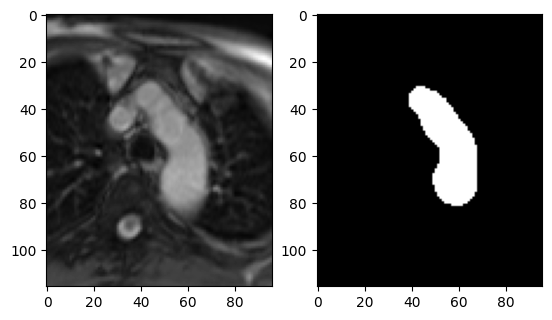

In [26]:
ig, axs = plt.subplots(1,2)

i = 0
axs[0].imshow(X_test[i,25,...,0],cmap='gray')
axs[1].imshow(y_pred[i,25,...,1],cmap='gray')

1/1 [==============================] - 0s 149ms/step


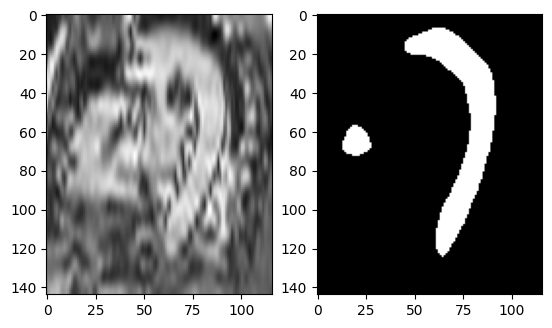

In [27]:
patient = patients[18]
X_test = []
test_gen   = CustomDataGenTest([patient], 'test').get_gen()
for X in test_gen:
    X=X[:,:,:,np.newaxis]
    X_test.append(X)
X_test = np.stack(X_test)
X_test.shape
y_pred = model.predict(X_test)
y_pred = get_one_hot(np.argmax(y_pred,axis = -1), 3)

ig, axs = plt.subplots(1,2)

i = 0
axs[0].imshow(X_test[i,...,60,0],cmap='gray')
axs[1].imshow(y_pred[i,...,60,1],cmap='gray')

In [13]:
from matplotlib import animation
patient = 'data/UKB200Goodcrop/1030585'
X_test = []
test_gen   = CustomDataGenTest([patient], 'test').get_gen()
for X in test_gen:
    X=X[:,:,:,np.newaxis]
    X_test.append(X)
X_test = np.stack(X_test)
y_pred = model.predict(X_test)
y_pred = get_one_hot(np.argmax(y_pred,axis = -1), 2)
fig, ax = plt.subplots(1,1, figsize = (3, 5)) #single plot but using a subplot to call it
frames = []
for i in range(y_pred.shape[-2]):
    p1 = ax.imshow(X_test[0,...,i,0],cmap = 'gray')
    p2 = ax.imshow(y_pred[0,...,i,1],alpha=y_pred[0,...,i,1] * 0.7,cmap = 'jet')
    frames.append([p1,p2])
fig.tight_layout()
ani = animation.ArtistAnimation(fig, frames)
ani.save(f'video.gif', fps=y_pred.shape[-2])
run[f"TestUKB200/{patient.split('/')[-1]}"].upload('video.gif')
plt.close()


1/1 [==============================] - 0s 148ms/step


In [15]:
patient = 'data/UKB200Goodcrop/1274962'
X_test = []
test_gen   = CustomDataGenTest([patient], 'test').get_gen()
for X in test_gen:
    X=X[:,:,:,np.newaxis]
    X_test.append(X)
X_test = np.stack(X_test)
y_pred = model.predict(X_test)
y_pred = get_one_hot(np.argmax(y_pred,axis = -1), 2)
fig, ax = plt.subplots(1,1, figsize = (3, 5)) #single plot but using a subplot to call it
frames = []
for i in range(y_pred.shape[1]):
    p1 = ax.imshow(X_test[0,i,...,0],cmap = 'gray')
    p2 = ax.imshow(y_pred[0,i,...,1],alpha=y_pred[0,i,...,1] * 0.7,cmap = 'jet')
    frames.append([p1,p2])
fig.tight_layout()
ani = animation.ArtistAnimation(fig, frames)
ani.save(f'video.gif', fps=y_pred.shape[-2])
run[f"TestUKBt200v/{patient.split('/')[-1]}"].upload('video.gif')
plt.close()

1/1 [==============================] - 0s 155ms/step


In [28]:
from matplotlib import animation

In [30]:
for id in val_patients: 
    X_test = []
    test_gen= CustomDataGenTest([id], 'test').get_gen()
    for X in test_gen:
        X=X[:,:,:,np.newaxis]
        X_test.append(X)
    X_test = np.stack(X_test)
    y_pred = model.predict(X_test)
    y_pred = get_one_hot(np.argmax(y_pred,axis = -1), 2)
    fig, ax = plt.subplots(1,1, figsize = (3, 5)) #single plot but using a subplot to call it
    frames = []
    for i in range(y_pred.shape[-2]):
        p1 = ax.imshow(X_test[0,...,i,0],cmap = 'gray')
        p2 = ax.imshow(y_pred[0,...,i,1],alpha=y_pred[0,...,i,1] * 0.7,cmap = 'jet')
        frames.append([p1,p2])
    fig.tight_layout()
    ani = animation.ArtistAnimation(fig, frames)
    ani.save(f"videos/model_29/{id.split('/')[-1]}.gif", fps=y_pred.shape[-2])
    run[f"UKB200new/{id.split('/')[-1]}"].upload(f"videos/model_29/{id.split('/')[-1]}.gif")
    print(id, f"UKB200new/model_29/{id.split('/')[-1]}")
    plt.close()

1/1 [==============================] - 0s 157ms/step
data/UKB200Goodcrop/2587029 UKB200new/model_29/2587029
1/1 [==============================] - 0s 160ms/step
data/UKB200Goodcrop/2236373 UKB200new/model_29/2236373
1/1 [==============================] - 0s 155ms/step
data/UKB200Goodcrop/5338806 UKB200new/model_29/5338806
1/1 [==============================] - 0s 158ms/step
data/UKB200Goodcrop/3665280 UKB200new/model_29/3665280
1/1 [==============================] - 0s 160ms/step
data/UKB200Goodcrop/1922576 UKB200new/model_29/1922576
1/1 [==============================] - 0s 160ms/step
data/UKB200Goodcrop/1551118 UKB200new/model_29/1551118
1/1 [==============================] - 0s 160ms/step
data/UKB200Goodcrop/4742655 UKB200new/model_29/4742655
1/1 [==============================] - 0s 159ms/step
data/UKB200Goodcrop/5355508 UKB200new/model_29/5355508
1/1 [==============================] - 0s 159ms/step
data/UKB200Goodcrop/4392412 UKB200new/model_29/4392412
1/1 [=======================

In [32]:
from skimage.measure import label   

def getLargestCC(segmentation):
    labels = label(segmentation)
    assert( labels.max() != 0 ) # assume at least 1 CC
    largestCC = labels == np.argmax(np.bincount(labels.flat)[1:])+1
    return largestCC

In [33]:
def clean_mask(mask):
    mask = get_one_hot(np.argmax(mask,axis = -1), 2)
    mask = np.squeeze(mask) #5d to 4d
    mask = mask[...,1] #4d to 3d
    mask = getLargestCC(mask) #clean
    mask = mask[np.newaxis,:,:,:,np.newaxis] #3d to 5d
    return mask

In [37]:
for id in patients: 
    X_test = []
    test_gen= CustomDataGenTest([id], 'test').get_gen()
    for X in test_gen:
        X=X[:,:,:,np.newaxis]
        X_test.append(X)
    X_test = np.stack(X_test)
    y_pred = model.predict(X_test)
    y_pred = clean_mask(y_pred)
    fig, ax = plt.subplots(1,1, figsize = (3, 5)) #single plot but using a subplot to call it
    frames = []
    for i in range(y_pred.shape[1]):
        p1 = ax.imshow(X_test[0,i,...,0],cmap = 'gray')
        p2 = ax.imshow(y_pred[0,i,...,0],alpha=y_pred[0,i,...,0] * 0.6,cmap = 'jet')
        frames.append([p1,p2])
    fig.tight_layout()
    ani = animation.ArtistAnimation(fig, frames)
    ani.save(f"videos/model_29TV/{id.split('/')[-1]}.gif", fps=y_pred.shape[1])
    run[f"UKB200tv/{id.split('/')[-1]}"].upload(f"videos/model_29TV/{id.split('/')[-1]}.gif")
    print(id, f"UKB200tv/model_29TV/{id.split('/')[-1]}")
    plt.close()

1/1 [==============================] - 0s 158ms/step
data/UKB200Goodcrop/4896701 UKB200tv/model_29TV/4896701
1/1 [==============================] - 0s 159ms/step
data/UKB200Goodcrop/4014366 UKB200tv/model_29TV/4014366
1/1 [==============================] - 0s 162ms/step
data/UKB200Goodcrop/1634705 UKB200tv/model_29TV/1634705
1/1 [==============================] - 0s 159ms/step
data/UKB200Goodcrop/3166651 UKB200tv/model_29TV/3166651
1/1 [==============================] - 0s 159ms/step
data/UKB200Goodcrop/2379928 UKB200tv/model_29TV/2379928
1/1 [==============================] - 0s 159ms/step
data/UKB200Goodcrop/1286881 UKB200tv/model_29TV/1286881
1/1 [==============================] - 0s 152ms/step
data/UKB200Goodcrop/3595863 UKB200tv/model_29TV/3595863
1/1 [==============================] - 0s 159ms/step
data/UKB200Goodcrop/2251838 UKB200tv/model_29TV/2251838
1/1 [==============================] - 0s 155ms/step
data/UKB200Goodcrop/3598289 UKB200tv/model_29TV/3598289
1/1 [==============

In [ ]:
33:16:16(3) 49/65=75%